# Diplomski rad 02
28\. veljače 2017.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.debugger import Tracer;

matplotlib.rcParams['figure.figsize'] = (12, 5)

sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)


- Konvencija: vremenski nizovi spremljeni su kao vektor-stupci
- **sp500** je matrica s cijenama dionica, **sp500_log** je matrica s logaritmima cijena dionica
- Definicija: **gornje-prizmoidni (3-D) tenzor** je tenzor koji duž prve dimenzije sadrži gornje-trokutaste matrice


## Funkcije
- `rolling_mean_variance(series, T)` računa očekivanje i varijancu nad zadanim podacima (`series`) nad pomičnim prozorom širine `T`
- `flatten_prismatic_tensor(K)` pretvara gornje-prizmoidni 3-D tenzor u 2-D tenzor koji u retcima sadrži izravnate gornje-trokutaste matrice originalnog tenzora
- `encode_pair`
- `encode_pairs`
- `decode_pair`
- `decode_pairs`


In [2]:
def rolling_mean_variance(series, T):
    L, N = series.shape
    if (L < T):
        return np.empty((0, N)), np.empty((0, N))
    mean = np.zeros((L - T + 1, N))
    var = np.zeros((L - T + 1, N))
    s0 = T * np.ones((1, N))
    s1 = np.sum(series[:T - 1, :], axis=0, keepdims=True)
    s2 = np.sum(series[:T - 1, :] ** 2, axis=0, keepdims=True)
    s1_prev = np.zeros((1, N))
    s2_prev = np.zeros((1, N))
    for i in range(L - T + 1):
        s1 += series[i + T - 1, :] - s1_prev
        s2 += series[i + T - 1, :] ** 2 - s2_prev
        s1_prev = series[i, :]
        s2_prev = series[i, :] ** 2
        mean[i, :] = s1 / s0
        var[i, :] = (s0 * s2 - s1 * s1) / (s0 * (s0 - 1))
    return mean, var

def rolling_window(series, T):
    shape = series.shape[:-1] + (series.shape[-1] - T + 1, T)
    strides = series.strides + (series.strides[-1],)
    return np.lib.stride_tricks.as_strided(series, shape=shape, strides=strides)

def rolling_minmax(series, T, minmax='min'):
    if minmax == 'min':
        np_argfun = np.argmin
        np_fun = np.min
    elif minmax == 'max':
        np_argfun = np.argmax
        np_fun = np.max
    else:
        raise Exception('"minmax" should be either "min" or "max".')
    
    # non-optimal
    return np_fun(rolling_window(series.transpose(), T), axis=1).transpose()

def flatten_prismatic_tensor(K):
    _, N, M = K.shape
    if N != M:
        raise Exception('Two lowest dimensions must be equal.')
    return np.array(list(map(lambda x: x[np.triu_indices(N, 1)], K)))

def calculate_pairwise_diffs(prices):
    days, N = prices.shape
    diffs = np.zeros((days, N, N))
    for i in range(N):
        for j in range(i + 1, N):
            diffs[:, i, j] = prices[:, i] - prices[:, j]
    return flatten_prismatic_tensor(diffs)

def encode_pair(i, j, N):
    if j < i:
        i, j = j, i
    return N * i + j - int((i + 1) * (i + 2) / 2)

def encode_pairs(ijs, N):
    return np.array([encode_pair(i, j, N) for i, j in ijs])

def decode_pair(c, N):
    b = 2 * N - 1
    b2 = b * b
    return __decode_pair(c, N, b, b2)

def decode_pairs(cs, N):
    b = 2 * N - 1
    b2 = b * b
    return np.array(np.vectorize(lambda c: __decode_pair(c, N, b, b2))(cs)).transpose()
        
def __decode_pair(c, N, b, b2):
    i = int((b - np.sqrt(b2 - 8 * c)) / 2)
    j = c - N * i + int((i + 1) * (i + 2) / 2)
    return i, j


## Prikaz primjera distribucije srednjih vrijednosti i varijanci

- **sp500_log_diffs** je izravnati gornje-trokutasti tenzor koji sadrži razlike parova dionica za svaki dan
- **sp500_log_diff_means**, **sp500_log_diff_vars**

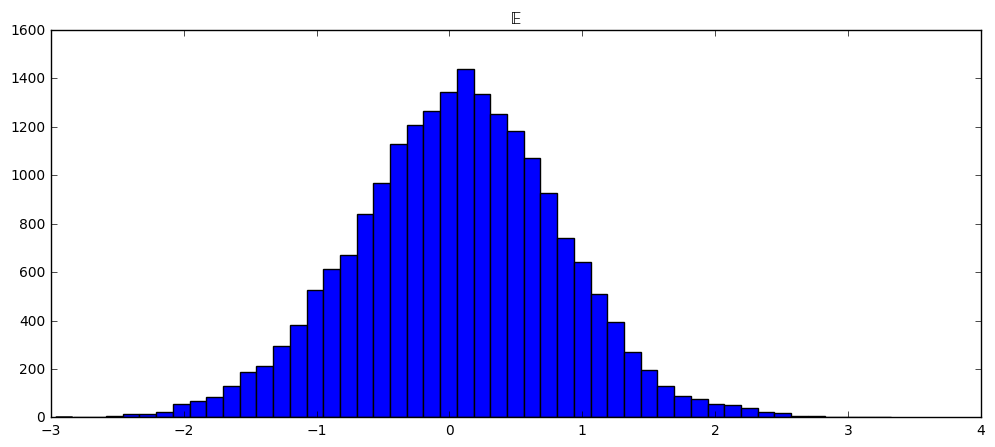

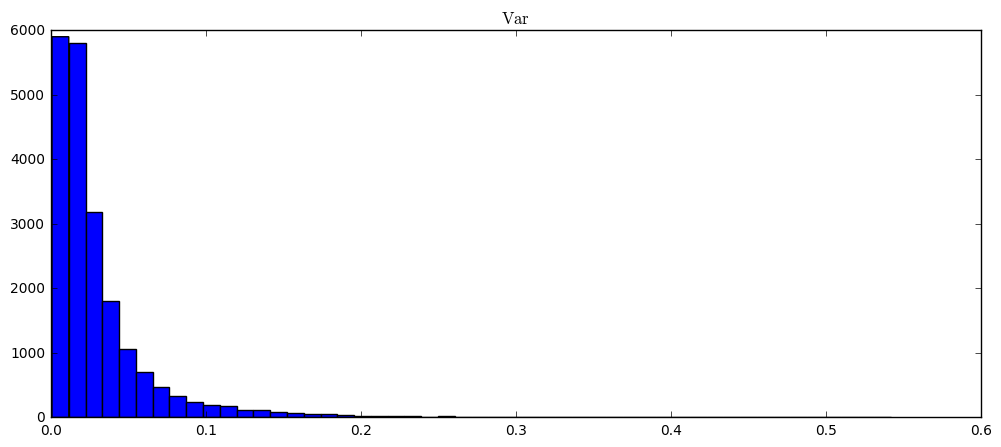

In [3]:
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

plt.figure()
plt.hist(sp500_log_diff_means[4321, :], 50)
plt.title('$\\mathrm{\\mathbb{E}}$')
plt.figure()
plt.hist(sp500_log_diff_vars[4321, :], 50);
plt.title('$\\mathrm{Var}$');

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)

## Prikaz parova dionica s najmanjim i najvećim varijancama

### Pobjednici

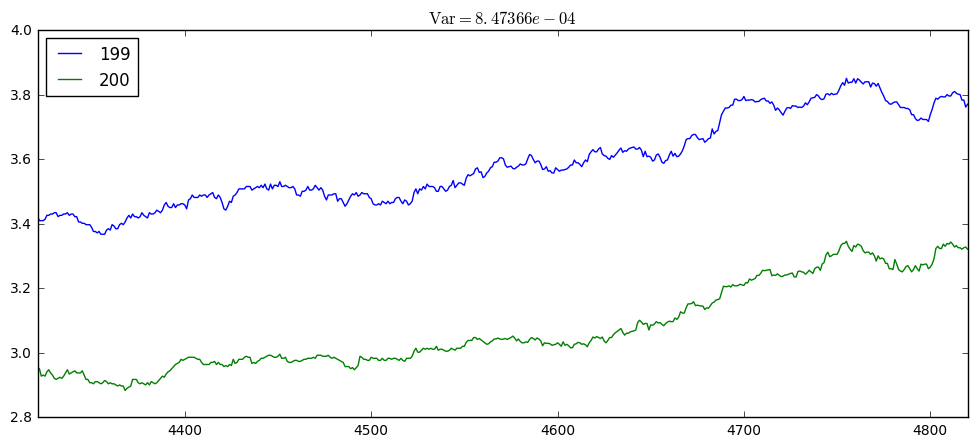

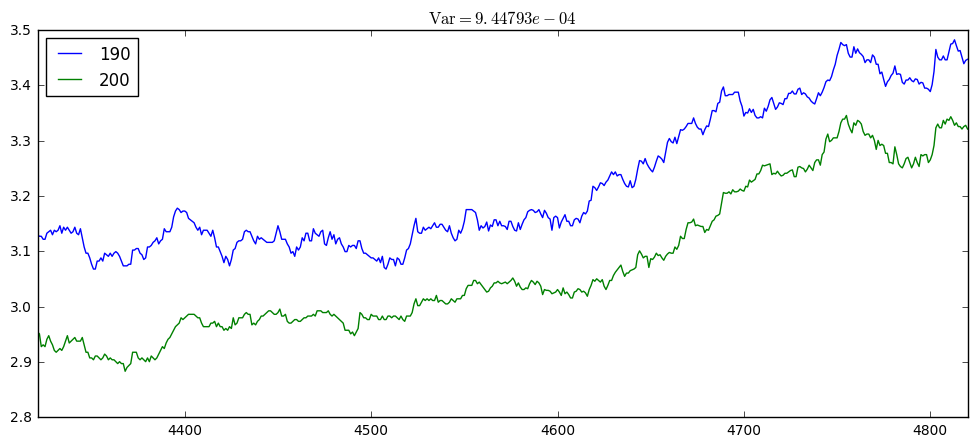

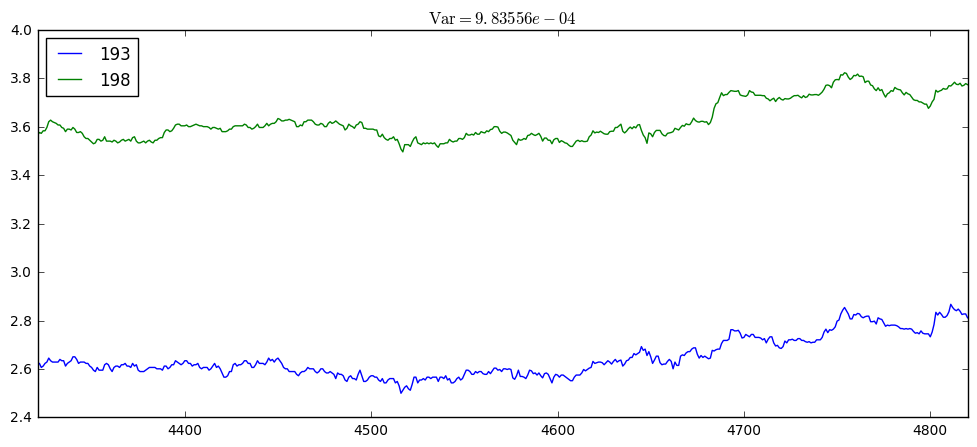

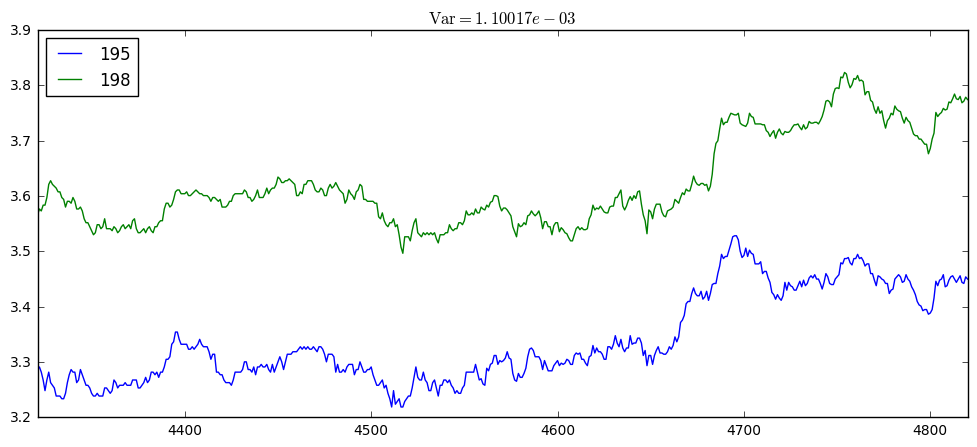

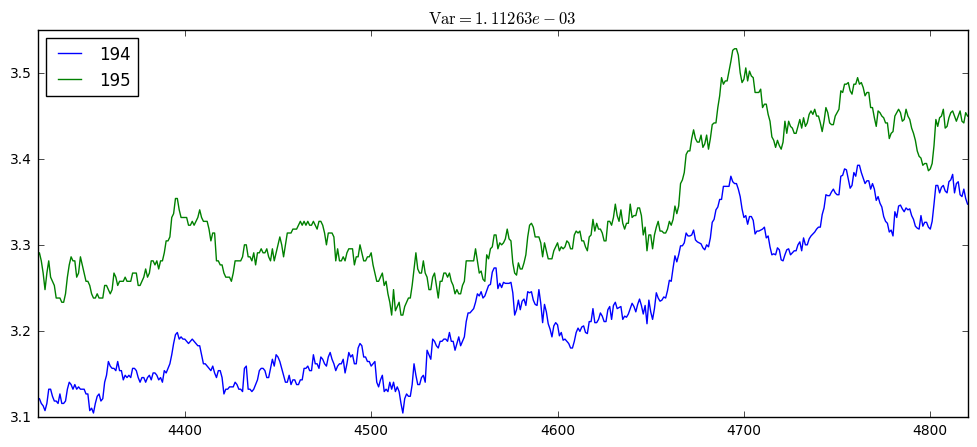

In [4]:
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
sp500_log_diff_stds = np.sqrt(sp500_log_diff_vars)

codes = sorted(list(range(pairs)), key=lambda c: sp500_log_diff_vars[4321, c])
sorted_vars = sorted(sp500_log_diff_vars[4321, :])
best = decode_pairs(codes[:5], N)
worst = decode_pairs(codes[-5:], N)

for (i, j), var in zip(best, sorted_vars[:5]):
    plt.figure()
    plt.plot(range(4321, 4321 + T), sp500_log[4321:4321 + T, i])
    plt.plot(range(4321, 4321 + T), sp500_log[4321:4321 + T, j])
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend((i, j), loc='best')
    plt.title('$\\mathrm{{Var}}={:.5e}$'.format(var))


### Gubitnici

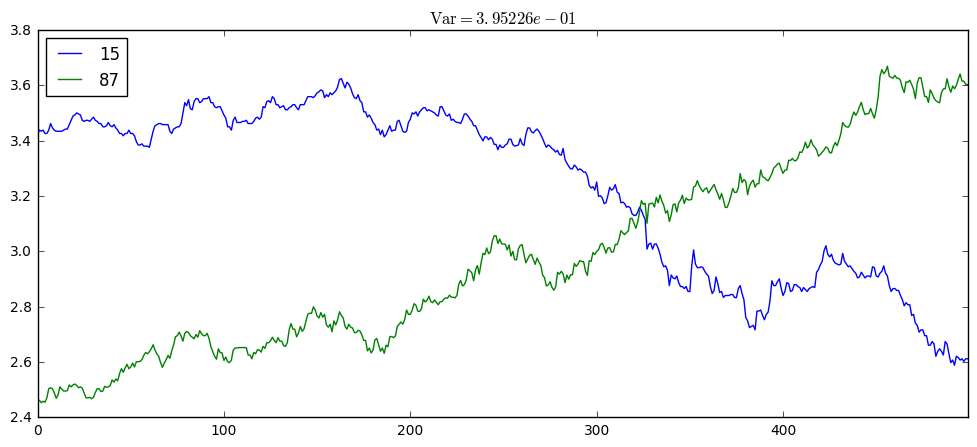

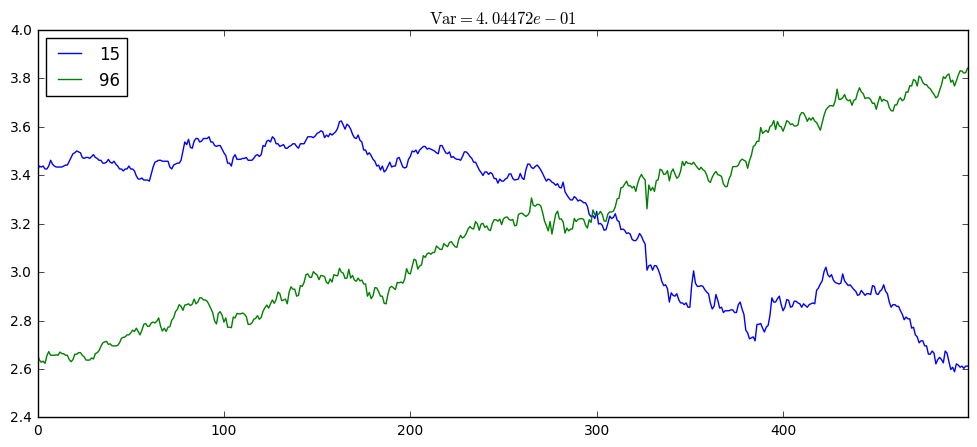

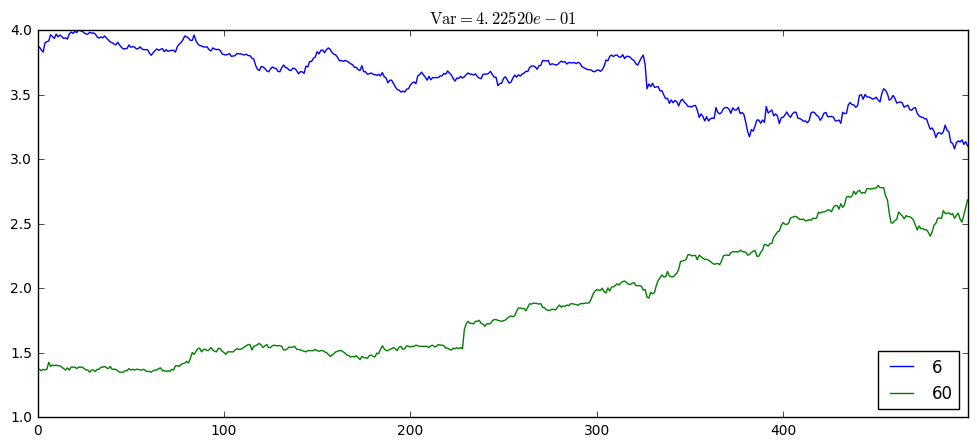

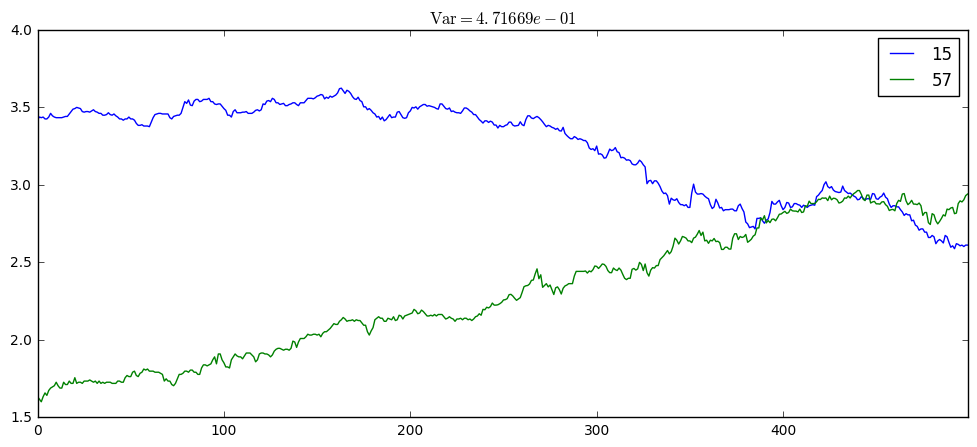

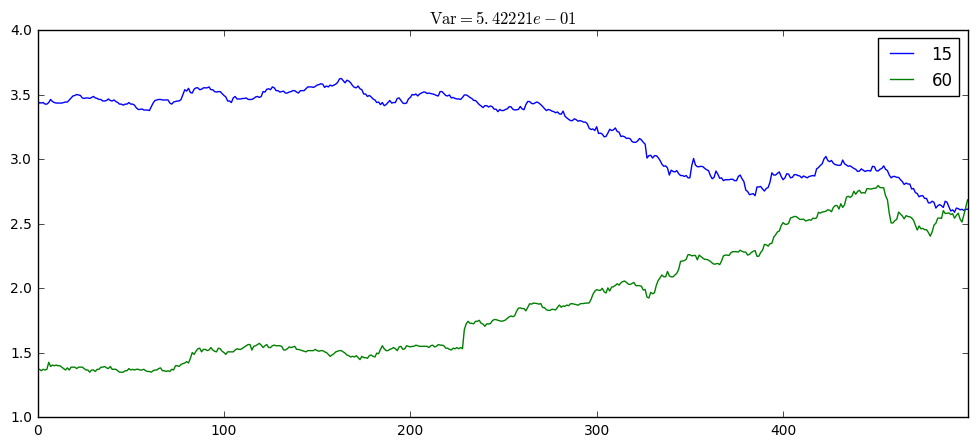

In [5]:
for (i, j), var in zip(worst, sorted_vars[-5:]):
    plt.figure()
    plt.plot(sp500_log[4321:4321 + T, i])
    plt.plot(sp500_log[4321:4321 + T, j])
    plt.legend((i, j), loc='best')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.title('$\\mathrm{{Var}}={:.5e}$'.format(var))
    

## Rasponi vrijednosti za parove s najmanjim varijancama

- **plavo:** dvije devijacije
- **zeleno:** polovica maksimalnog odstupanja

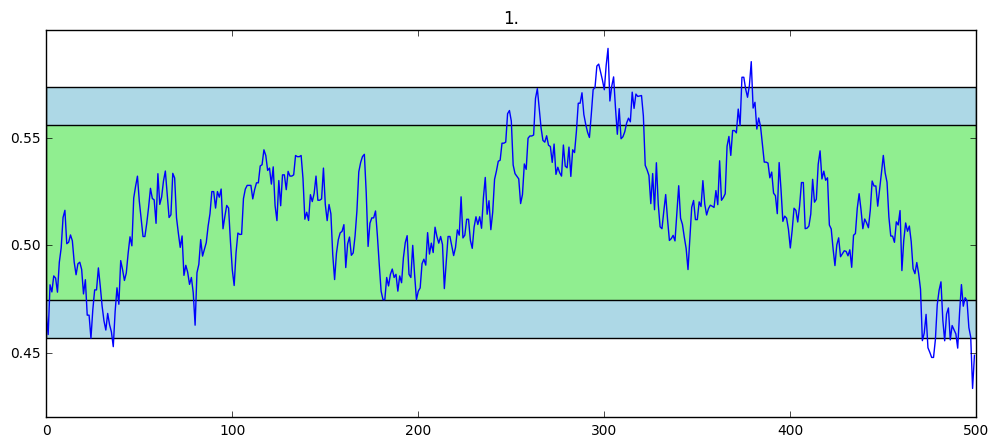

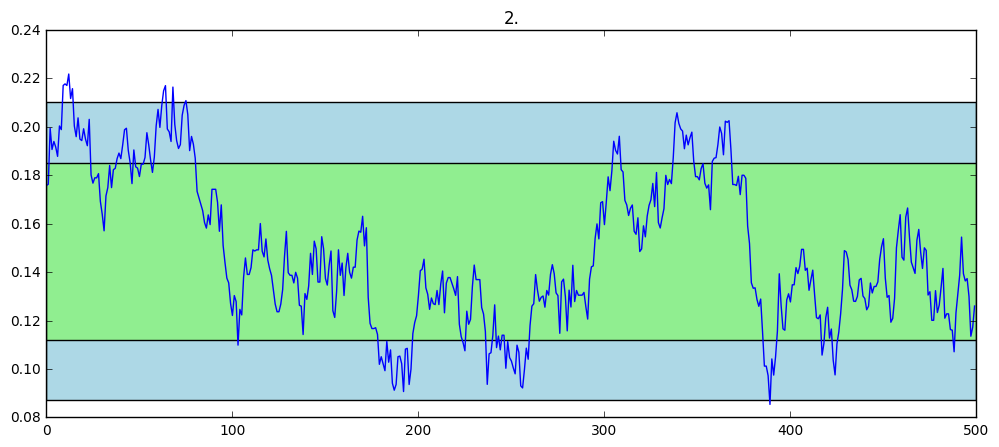

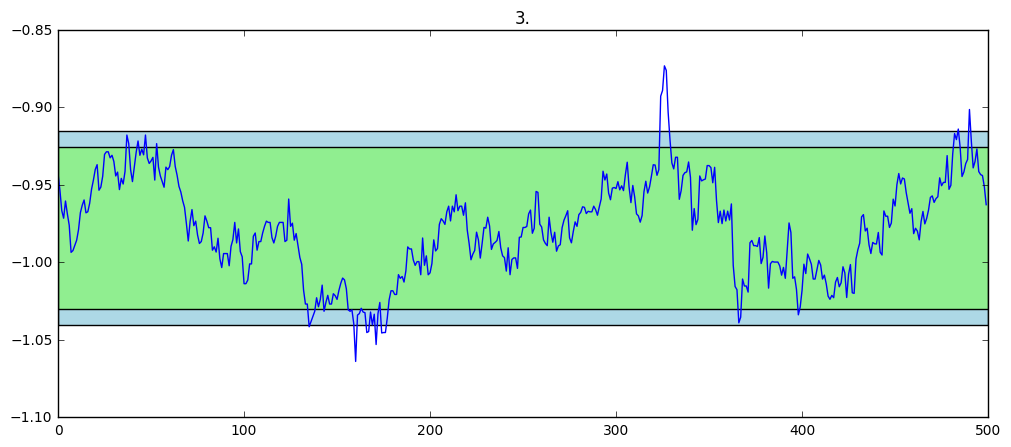

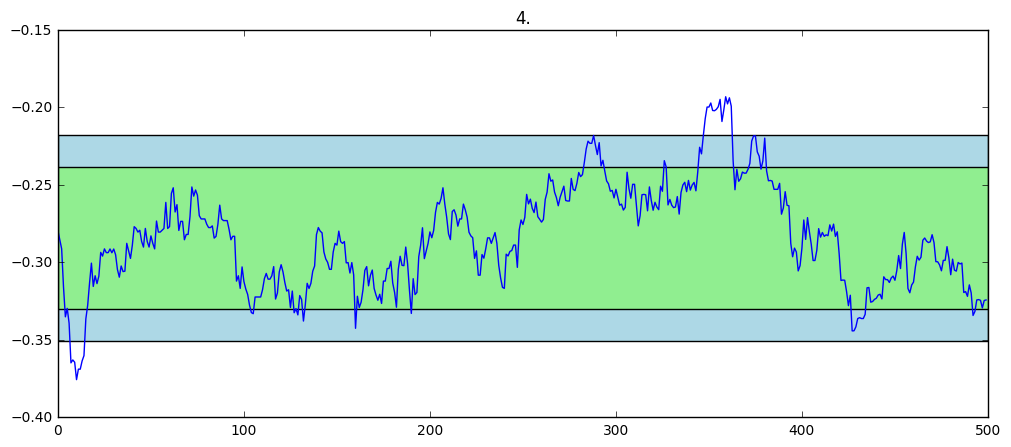

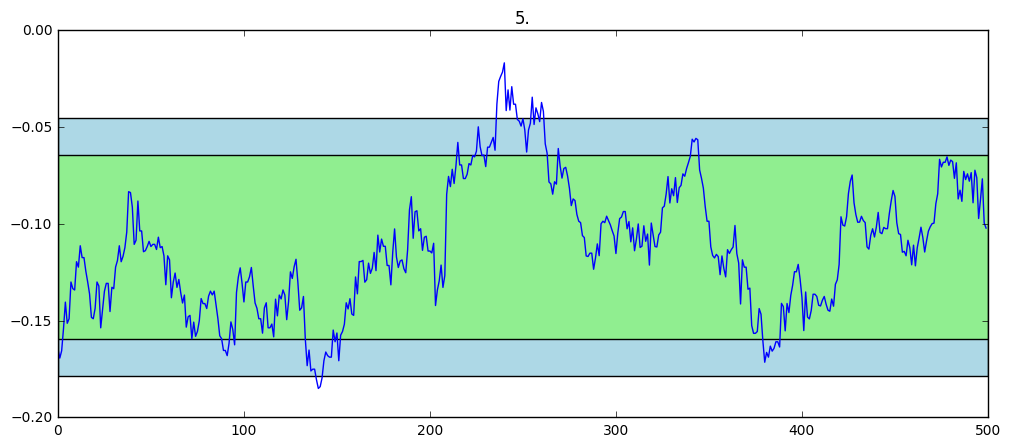

In [6]:
for i in range(5):
    plt.figure()
    plt.plot(sp500_log_diffs[4321:4321 + T, codes[i]])
    y1 = sp500_log_diff_means[4321, codes[i]] - 2 * sp500_log_diff_stds[4321, codes[i]]
    y2 = sp500_log_diff_means[4321, codes[i]] + 2 * sp500_log_diff_stds[4321, codes[i]]
    max_abs_dev = np.max(np.abs(sp500_log_diffs[4321:4321 + T - 1, codes[i]] - sp500_log_diff_means[4321, codes[i]]))
    z1 = sp500_log_diff_means[4321, codes[i]] - 0.5 * max_abs_dev
    z2 = sp500_log_diff_means[4321, codes[i]] + 0.5 * max_abs_dev
    plt.fill_between(range(501), y1, y2, facecolor='lightblue')
    plt.fill_between(range(501), z1, z2, facecolor='lightgreen')
    plt.title(str(i + 1) + '.')
    
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, sp500_log_diff_stds,
    codes, sorted_vars, best, worst)

# Statistička arbitraža

- **trade_pair**
- **trade_pairs**
- **select_argsort**
- **statistical_arbitrage**

In [7]:
def trade_pair(diffs, t, pair, inv=False):
    P = diffs.shape[1]
    N = int(np.sqrt(8 * P + 1) / 2 - 1.5)
    
    if isinstance(pair, tuple):
        i, j = tuple
        c = encode_pair(i, j, N)
    elif np.issubdtype(pair, np.integer):
        c = pair
    else:
        raise Exception('"pair" should be either tuple or int.')
        
    return (1 - 2 * inv) * (diffs[t, c] - diffs[t + 1, c])

def trade_pairs(diffs, ts, pairs, inv=False):
    P = diffs.shape[1]
    N = int(np.sqrt(8 * P + 1) / 2 - 1.5)
    
    if len(pairs.shape) == 2:
        cs = encode_pairs(pairs, N)
    elif len(pairs.shape) == 1:
        cs = pairs
    else:
        raise Exception('"pairs" should be one- or two-dimensional.')
        
    return np.array([trade_pair(diffs, t, c, inv) for t, c in zip(ts, cs)])

def select_argsort(matrix, argsort):
    n, _ = matrix.shape
    _, l = argsort.shape
    return matrix[np.arange(n).repeat(l), argsort.ravel()].reshape((n, l))

def statistical_arbitrage(diffs, means, varss, p, d, method='devs'):
    T = diffs.shape[0] - means.shape[0] + 1
    P = diffs.shape[1]
    L = means.shape[0]    
    
    if isinstance(p, float):
        p = int(p * P)
    elif not isinstance(p, int):
        raise Exception('"p" should be either int or float.')
    
    selected_codes = np.argsort(varss, axis=1)[:-1, :p]
    selected_diffs = select_argsort(diffs[T - 1:-1, :], selected_codes)
    selected_means = select_argsort(means[:-1, :], selected_codes)
    selected_vars = select_argsort(varss[:-1, :], selected_codes)
    
    if method == 'devs':
        lower_bounds = selected_means - d * np.sqrt(selected_vars)
        upper_bounds = selected_means + d * np.sqrt(selected_vars)
        ts_invs, invs = np.nonzero(np.less(selected_diffs, lower_bounds))
        ts_no_invs, no_invs = np.nonzero(np.greater(selected_diffs, upper_bounds))
        invs = selected_codes[ts_invs, invs]
        no_invs = selected_codes[ts_no_invs, no_invs]
        ts_invs += T - 1
        ts_no_invs += T - 1
        
    elif method == 'max-abs-devs':
        max_abs_devs = select_argsort(
            np.max(np.abs(rolling_window(diffs.transpose(), T).transpose() - means), axis=0)[:-1, :],
            selected_codes)
        lower_bounds = selected_means - d * max_abs_devs
        upper_bounds = selected_means + d * max_abs_devs
        ts_invs, invs = np.nonzero(np.less(selected_diffs[1:, :], lower_bounds[:-1, :]))
        ts_no_invs, no_invs = np.nonzero(np.greater(selected_diffs[1:, :], upper_bounds[:-1, :]))
        ts_invs += 1
        ts_no_invs += 1
        invs = selected_codes[ts_invs, invs]
        no_invs = selected_codes[ts_no_invs, no_invs]
        ts_invs += T - 1
        ts_no_invs += T - 1
        
    else:
        raise Exception('Method not supported.')
    
    invs_profit = trade_pairs(diffs, ts_invs, invs, True)
    no_invs_profit = trade_pairs(diffs, ts_no_invs, no_invs, False)
    ts_total = np.append(ts_invs, ts_no_invs)
    ts_order = np.argsort(ts_total)
    profit = np.append(invs_profit, no_invs_profit)[ts_order]
    ts_total = ts_total[ts_order]
    return ts_total, profit


## Testiranje implementacije nad trivijalnim podacima

[[ 1.  -2.6 -3.6]
 [ 1.2 -4.3 -5.5]
 [ 1.2 -2.5 -3.7]
 [ 1.2 -4.3 -5.5]
 [ 1.2 -2.5 -3.7]
 [ 1.2 -4.3 -5.5]
 [ 1.  -2.6 -3.6]
 [ 0.8 -4.5 -5.3]
 [ 0.8 -2.7 -3.5]]
[[  0.    24.3   24.3 ]
 [  0.2   23.45  25.25]
 [  0.2   23.    25.7 ]
 [  0.2   23.45  25.25]
 [  0.2   23.    25.7 ]
 [  0.2   23.45  25.25]
 [  0.    24.3   24.3 ]
 [  0.2   25.25  23.45]
 [  0.2   25.7   23.  ]]
[ 5 11]
[ 1.  1.]


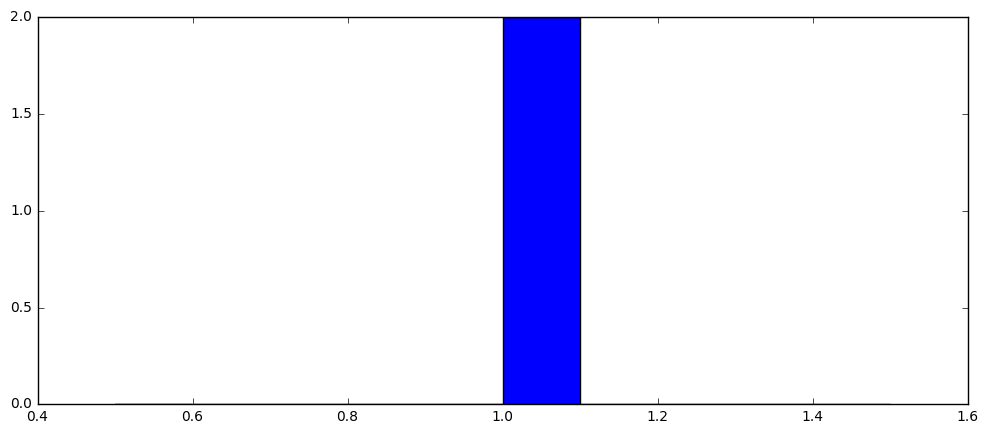

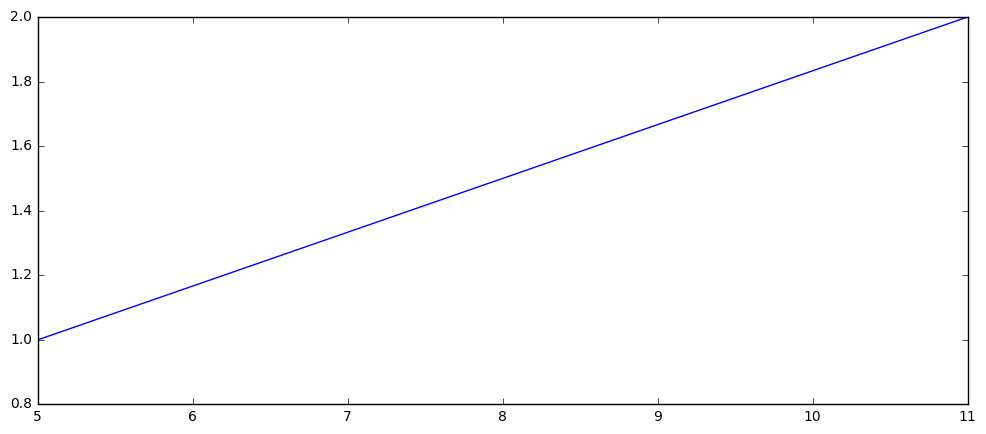

In [8]:
my_prices_logs = np.array([
        [2, 2, 2, 2, 2, 2.5, 2, 2, 2, 2, 2, 1.5, 2],
        [1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1.5, 1],
        [1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1]
        ]).transpose();

my_prices_diffs = calculate_pairwise_diffs(my_prices_logs)
my_prices_means, my_prices_vars = rolling_mean_variance(my_prices_diffs, 5)

ts, profit = statistical_arbitrage(my_prices_diffs, my_prices_means, my_prices_vars,
                                   1, 1, method='devs')

print(my_prices_means)
print(my_prices_vars)
print(ts)
print(profit)

plt.figure()
plt.hist(profit)
plt.figure()
plt.plot(ts, np.cumsum(profit));

## Statistička arbitraža na podskupu podataka &ndash; metoda 'devs', trgovanje najviše jednim parom

### Deset dionica

1.3887095951
0.507323568575


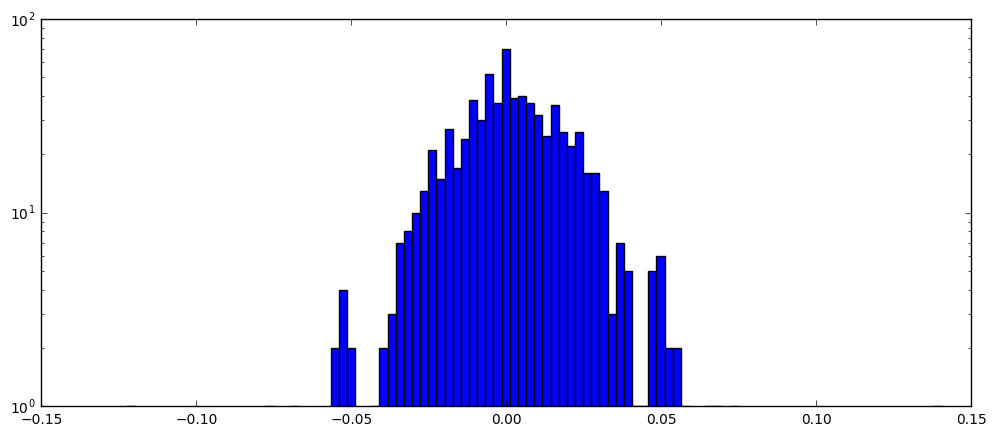

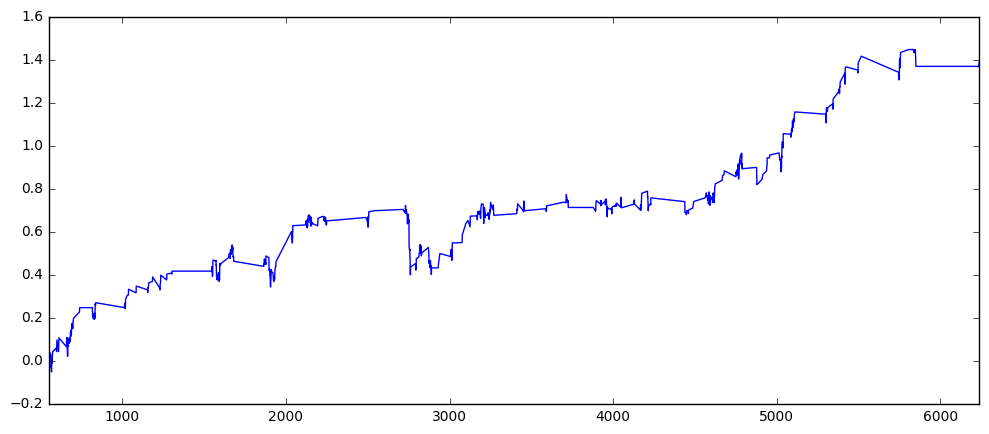

In [9]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500 = sp500[:, :10]
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

p = 1
d = 2
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                   p, d, method='devs')

plt.figure()
plt.hist(profit, 100)
plt.yscale('log', nonposy='clip')
plt.figure()
plt.plot(ts, np.cumsum(profit))
plt.autoscale(enable=True, axis='x', tight=True)
print(np.sum(profit))
print(np.sum(profit > 0) / len(profit))

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


### Deset po deset dionica (bez preklapanja)

13.3049481377
0.515389116442


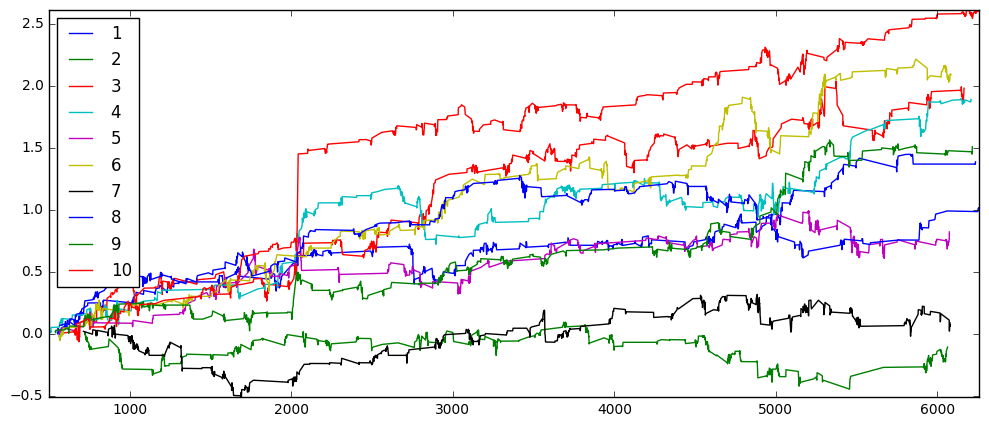

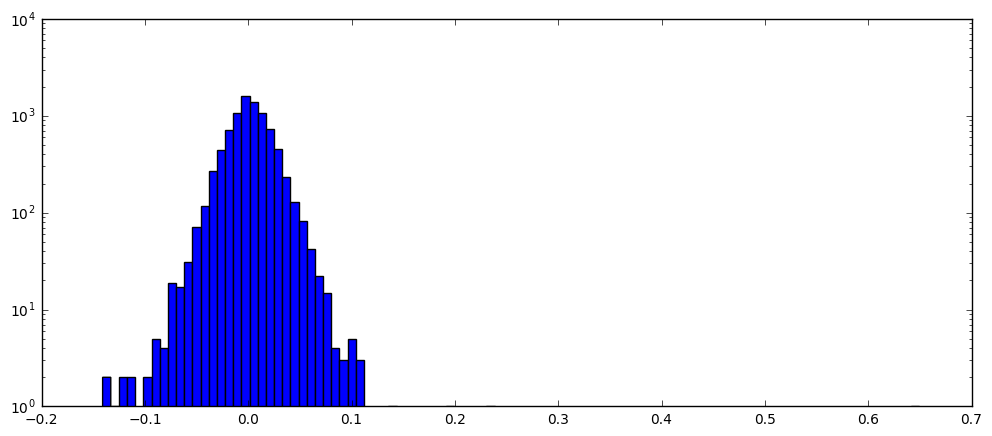

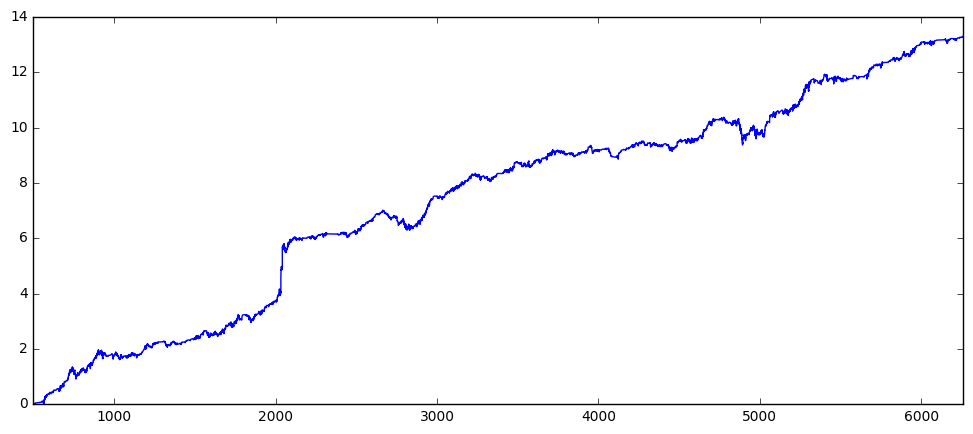

In [10]:
tss = np.array([])
profits = np.array([])
sp500_all = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')

plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
for i in range(10):
    sp500 = sp500_all[:, 10 * i:10 * i + 10]
    sp500_log = np.log(sp500)
    days, N = sp500.shape
    pairs = int(N * (N - 1) / 2)

    p = 1
    d = 2
    T = 500

    sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
    sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
    ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                       p, d, method='devs')
        
    plt.plot(ts, np.cumsum(profit))
    
    tss = np.append(tss, ts)
    profits = np.append(profits, profit)
    
plt.legend([str(i + 1) for i in range(10)], loc='best')

ts_order = np.argsort(tss)
tss = tss[ts_order]
profits = profits[ts_order]

plt.figure()
plt.hist(profits, 100)
plt.yscale('log', nonposy='clip')
plt.figure()
plt.plot(tss, np.cumsum(profits))
plt.autoscale(enable=True, axis='x', tight=True)
print(np.sum(profits))
print(np.sum(profits > 0) / len(profits))

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, sp500_all)


## Statistička arbitraža na podskupu podataka &ndash; metoda 'max-abs-devs', trgovanje najviše jednim parom

### Deset dionica

2.4952182172
0.513650793651


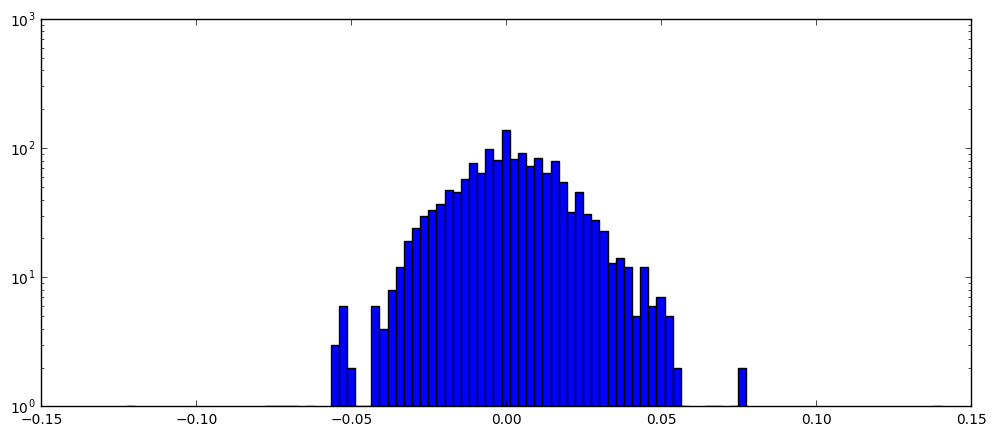

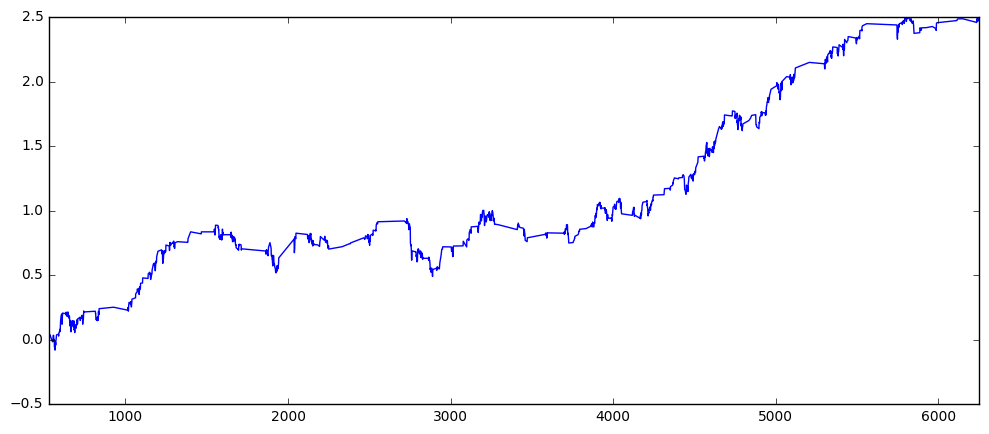

In [11]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500 = sp500[:, :10]
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

p = 1
d = 0.5
T = 500

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                   p, d, method='max-abs-devs')

plt.figure()
plt.hist(profit, 100)
plt.yscale('log', nonposy='clip')
plt.figure()
plt.plot(ts, np.cumsum(profit))
plt.autoscale(enable=True, axis='x', tight=True)
print(np.sum(profit))
print(np.sum(profit > 0) / len(profit))

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


### Deset po deset dionica (bez preklapanja)

21.2072128345
0.502816674714


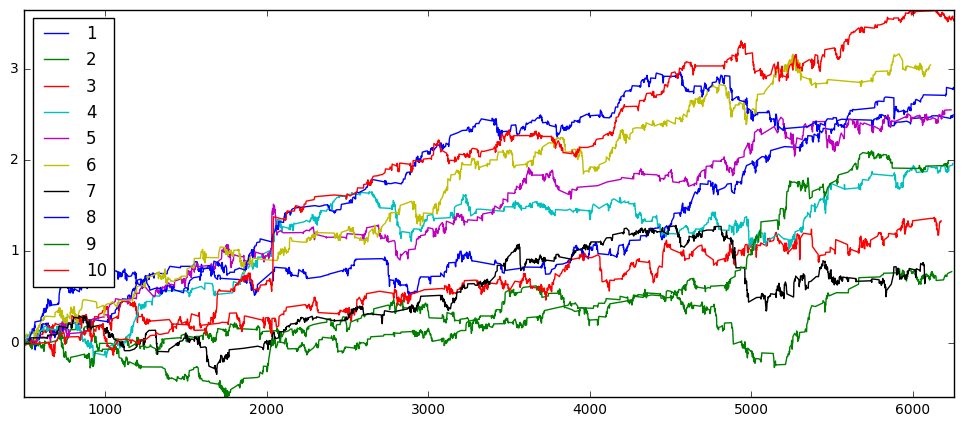

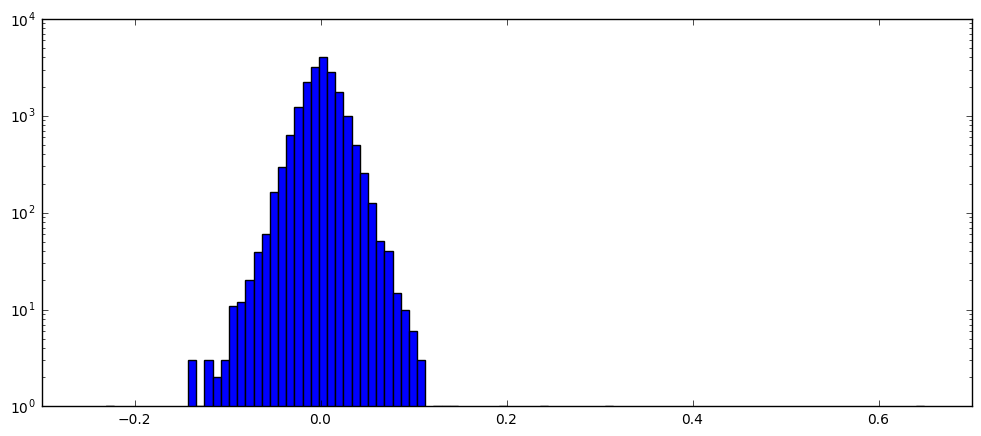

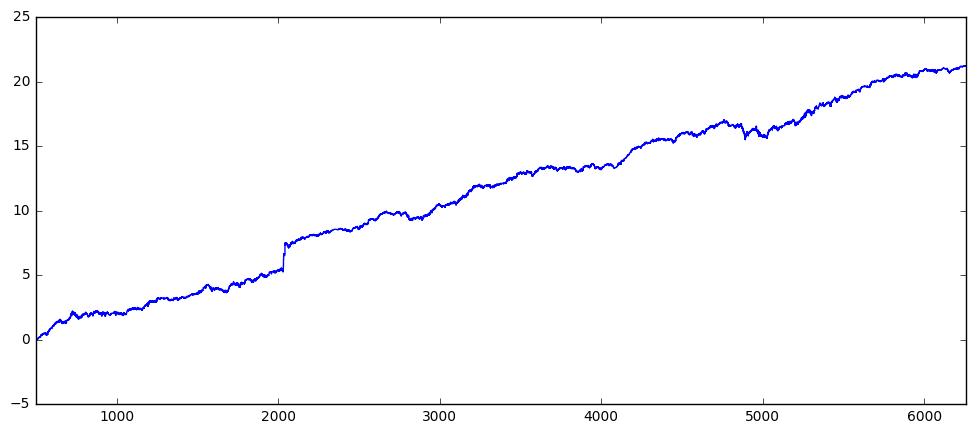

In [12]:
tss = np.array([])
profits = np.array([])
sp500_all = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')

plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
for i in range(10):
    sp500 = sp500_all[:, 10 * i:10 * i + 10]
    sp500_log = np.log(sp500)
    days, N = sp500.shape
    pairs = int(N * (N - 1) / 2)

    p = 1
    d = 0.5
    T = 500

    sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
    sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
    ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                       p, d, method='max-abs-devs')
        
    plt.plot(ts, np.cumsum(profit))
    
    tss = np.append(tss, ts)
    profits = np.append(profits, profit)
    
plt.legend([str(i + 1) for i in range(10)], loc='best')

ts_order = np.argsort(tss)
tss = tss[ts_order]
profits = profits[ts_order]

plt.figure()
plt.hist(profits, 100)
plt.yscale('log', nonposy='clip')
plt.figure()
plt.plot(tss, np.cumsum(profits))
plt.autoscale(enable=True, axis='x', tight=True)
print(np.sum(profits))
print(np.sum(profits > 0) / len(profits))

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, sp500_all)


## Variranje parametara p i d

p = 1, d = 1, profit = 2.1220242573330674
p = 1, d = 1.3, profit = 2.294342275033248
p = 1, d = 1.5, profit = 1.5048623100425638
p = 1, d = 1.8, profit = 1.1976307474024157
p = 1, d = 2, profit = 0.7980151799479933
p = 1, d = 2.5, profit = 0.6092372031058312
p = 1, d = 3, profit = 0.24956525385334838
p = 2, d = 1, profit = 4.407319201347283
p = 2, d = 1.3, profit = 3.9437315593718116
p = 2, d = 1.5, profit = 2.821125926702887
p = 2, d = 1.8, profit = 2.060667248338074
p = 2, d = 2, profit = 1.3344427964697285
p = 2, d = 2.5, profit = 1.3430362135654406
p = 2, d = 3, profit = 0.5838228764218265
p = 5, d = 1, profit = 15.884660391273218
p = 5, d = 1.3, profit = 11.651273330393275
p = 5, d = 1.5, profit = 8.481290233531471
p = 5, d = 1.8, profit = 6.388185001230899
p = 5, d = 2, profit = 4.712596771811869
p = 5, d = 2.5, profit = 3.1294169257291324
p = 5, d = 3, profit = 1.4627646164432384
p = 10, d = 1, profit = 29.807005730769145
p = 10, d = 1.3, profit = 23.736288951936583
p = 10, d = 

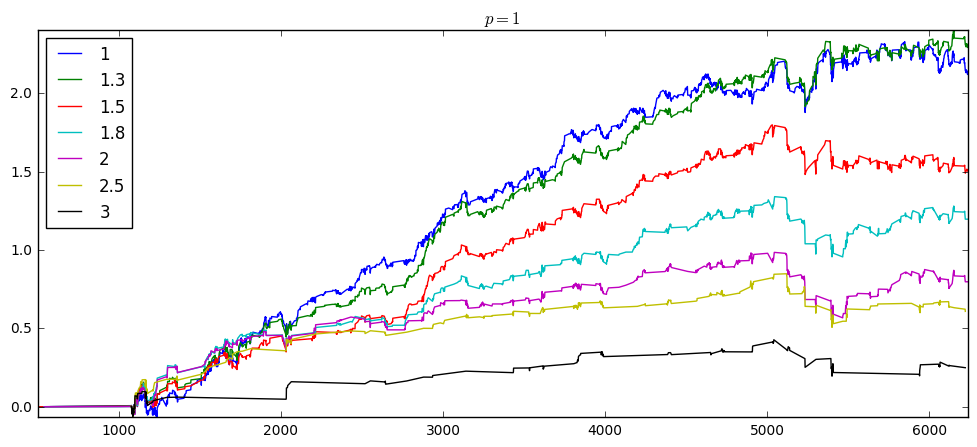

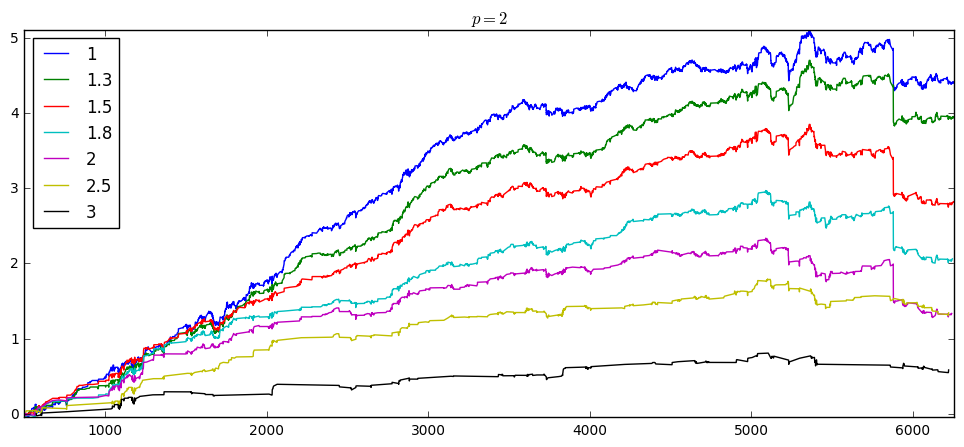

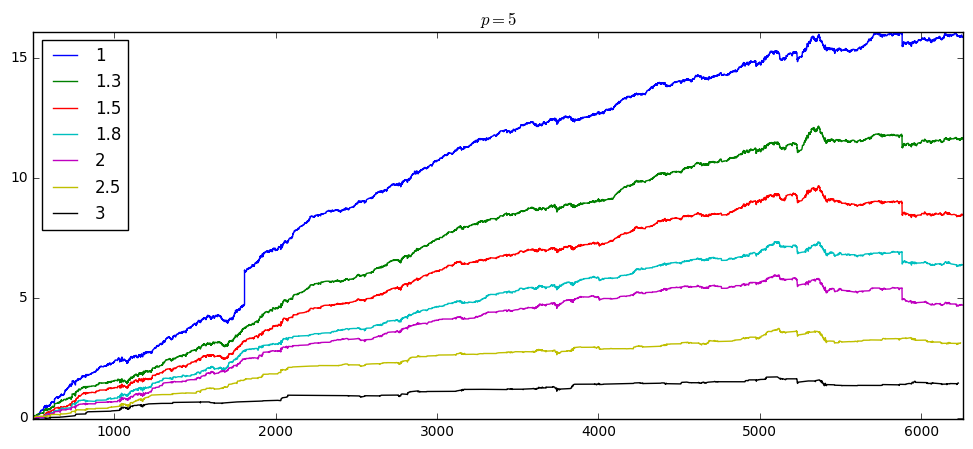

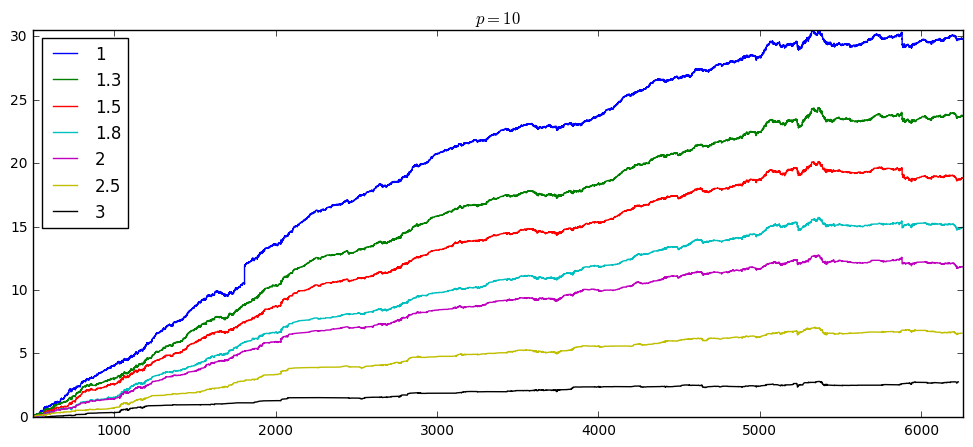

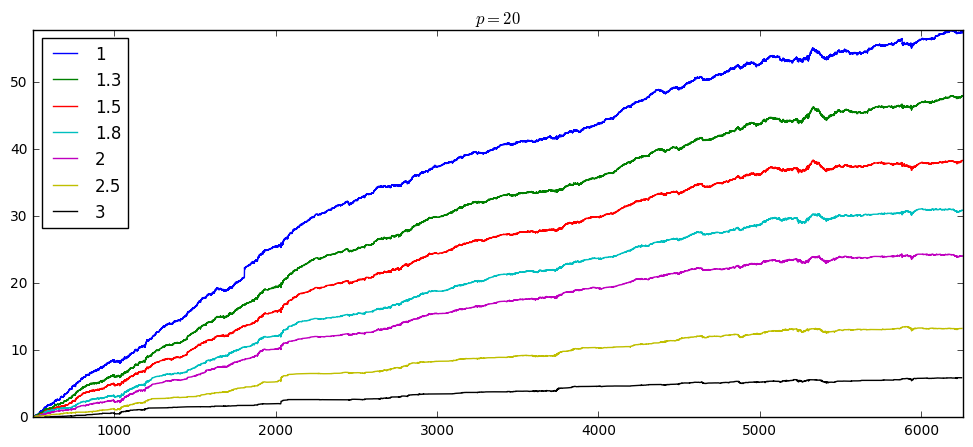

In [20]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

T = 500
ps = [1, 2, 5, 10, 20]
ds = [1, 1.3, 1.5, 1.8, 2, 2.5, 3]

for p in ps:
    plt.figure()
    plt.title('$p={}$'.format(p))
    for d in ds:
        sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
        sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

        ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                           p, d, method='devs')

        plt.plot(ts, np.cumsum(profit))
        plt.autoscale(enable=True, axis='x', tight=True)
        print('p = {}, d = {}, profit = {}'.format(p, d, np.sum(profit)))
    plt.legend([str(d) for d in ds], loc='best')

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)
